In [1]:
import tensorflow as tf
import tensorflow.contrib as tcb
from tensorflow.contrib.learn.python.learn.learn_io.numpy_io import numpy_input_fn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
    

In [2]:
def model_fn(features, labels, mode, params):
    # get features

    X = features["X"]
    Y = features["Y"]
    
    inputs = tf.concat([X, Y], axis = 1) # b * 2
    print(X.shape, Y.shape, labels.shape, inputs.shape)

    p = params.get("p", 1)

    W = tf.get_variable("W", shape=(2, p), dtype = tf.float64) # 2 * p
    b = tf.get_variable("b", shape=(1, p), dtype = tf.float64) # 1 * p but will get broadcasted to batch size by tf => b * p

    out1 = tf.matmul(inputs, W) + b # b * p
    out2 = tf.nn.relu(out1) # b * p
    predictions = tcb.layers.fully_connected(out2, num_outputs=1)

    # prediction part

    if mode == tcb.learn.ModeKeys.INFER:
        return tcb.learn.ModelFnOps(
            mode= mode,
            predictions = predictions,
            loss = None,
            train_op = None
        )

    # training part => fit

    loss = tf.losses.mean_squared_error(labels, predictions)
    learning_rate = params.get("learning_rate", 1e-5)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    tf.Print(loss, [inputs, labels])
    
    global_step = tf.contrib.framework.get_global_step()
    train_op = tf.group(optimizer, tf.assign_add(global_step, 1))

#     train_op = tcb.layers.optimize_loss(loss=loss,
#                                         global_step = tf.contrib.framework.get_global_step(),
#                                         learning_rate=learning_rate,
#                                         optimizer = "SGD")

    return tcb.learn.ModelFnOps(
        mode = mode,
        predictions = predictions,
        loss = loss,
        train_op = train_op
    )


In [13]:
import numpy as np
# X = np.array(range(1, 51) ,dtype=np.float64).reshape(-1, 1) *  1.0
# Y = np.array(range(0, 100, 2), dtype=np.float64).reshape(-1, 1) * 1.0
# X1, Y1 = np.meshgrid(X, Y)
# X = X1.reshape(-1, 1)
# Y = Y1.reshape(-1, 1)
# Z = X + Y
# print(X.shape, Y.shape, Z.shape)

X = np.linspace(-5,5)
Y = np.linspace(-5,5)
X, Y = np.meshgrid(X, Y)

Z = 100*np.exp(-1*(X**2 + Y**2)/5)

X = X.reshape(-1,1)
Y = Y.reshape(-1,1)
Z = Z.reshape(-1,1)

In [14]:
input_fn = numpy_input_fn(x= {"X": X, "Y": Y}, y = Z, batch_size=100, num_epochs=10, shuffle=True)

In [23]:
estimator = tcb.learn.Estimator(model_fn=model_fn, params={"learning_rate": 1e-2, "p": 5})

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x113b68f90>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


In [24]:
y = estimator.fit(input_fn=input_fn)

(TensorShape([Dimension(None), Dimension(1)]), TensorShape([Dimension(None), Dimension(1)]), TensorShape([Dimension(None), Dimension(1)]), TensorShape([Dimension(None), Dimension(2)]))
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/1k/0mbw6yb531v01963w262zblc682jgh/T/tmpEelUTB/model.ckpt.
INFO:tensorflow:loss = 11.925115, step = 1
INFO:tensorflow:global_step/sec: 839.363
INFO:tensorflow:loss = 350.92743, step = 101
INFO:tensorflow:global_step/sec: 790.47
INFO:tensorflow:loss = 304.8067, step = 201
INFO:tensorflow:Saving checkpoints for 251 into /var/folders/1k/0mbw6yb531v01963w262zblc682jgh/T/tmpEelUTB/model.ckpt.
INFO:tensorflow:Loss for final step: 747.1141.


In [25]:
predict_input_fn = numpy_input_fn(x= {"X": X, "Y": Y}, y = Z, batch_size=5, num_epochs=1, shuffle=False)
Zgo = estimator.predict(input_fn=predict_input_fn)
Zout = np.array([x[0] for x in Zgo])

(TensorShape([Dimension(None), Dimension(1)]), TensorShape([Dimension(None), Dimension(1)]), TensorShape([Dimension(None), Dimension(1)]), TensorShape([Dimension(None), Dimension(2)]))


In [26]:

def plot3d(x, y, z):
    l = int(np.sqrt(x.shape[0]))
    x1 = x.reshape(l,l)
    y1 = y.reshape(l,l)
    z1 = z.reshape(l,l)
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    surf = ax.plot_surface(x1, y1, z1, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    plt.show()

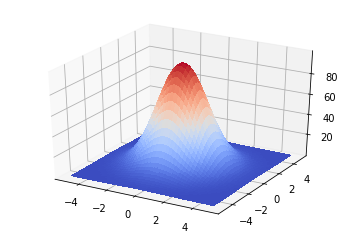

In [27]:
plot3d(X,Y,Z)

In [28]:
Zout

array([0., 0., 0., ..., 0., 0., 0.])

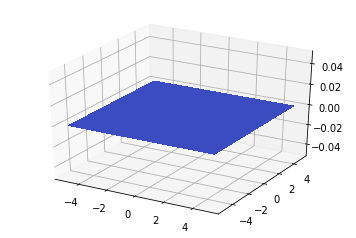

In [30]:
plot3d(X,Y, Zout)